In [34]:
# Standard and OS :
import copy
import json
import glob
import os
import importlib # Required to reload a module
                 # because the Jupyter Kernel
                 # won't  really reimport by itself.
import multiprocessing as mp

# Image processing :
import skimage
import cv2 as cv

# Numeric :
import numpy as np
import pandas as pd

# Visualisation :
import matplotlib.pyplot as plt
import seaborn as sns

# Machine-Learning :
from sklearn.cluster import KMeans

# Functional programing tools : 
from functools import partial, reduce
from itertools import chain


In [2]:
import mfilt_funcs as mfs
importlib.reload(mfs)
import mfilt_funcs as mfs

import utils
importlib.reload(utils)
import utils

In [3]:
lmap = lambda x, y: list(map(x, y))
lfilter = lambda x, y: list(filter(x, y))
imread = lambda x: cv.imread(x, 0)

In [4]:
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (12, 8)

In [5]:
ls images/

Triangulos.PNG   altoflujo.png    bajo2flujo.png   triangulos2.jpg
alto2flujo.png   bajo1flujo.png   bajo3flujo.png


In [6]:
cwd  = os.path.abspath('.')
path = os.path.join(cwd, 'images')
pattern = os.path.join(path, '*flujo.png')
files = glob.glob(pattern)
files

['/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/altoflujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo1flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo2flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo3flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/alto2flujo.png']

Todas nuestras imágenes de interés contienen la cadena de caracteres 'flujo.png'.

In [7]:
mangueras = {
    f"{nombre}": imread(file) for file, nombre in zip(files, lmap(lambda x: os.path.split(x)[-1], files)) 
}

In [8]:
intensities = pd.core.frame.DataFrame({
    key: mangueras[key].flatten() for key in mangueras.keys()
})

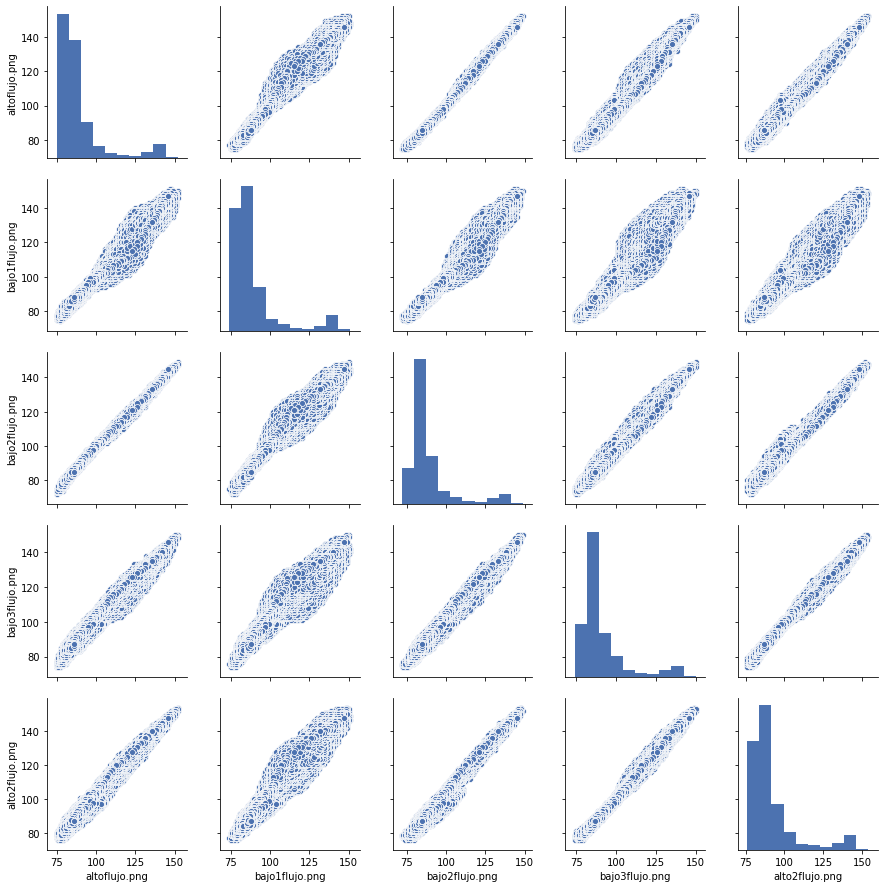

In [9]:
# SUPER SLOW ! 
# Do not run !
sns.pairplot(intensities)

Podemos observar una gran correlación entre las intensidades de todas las imágenes.

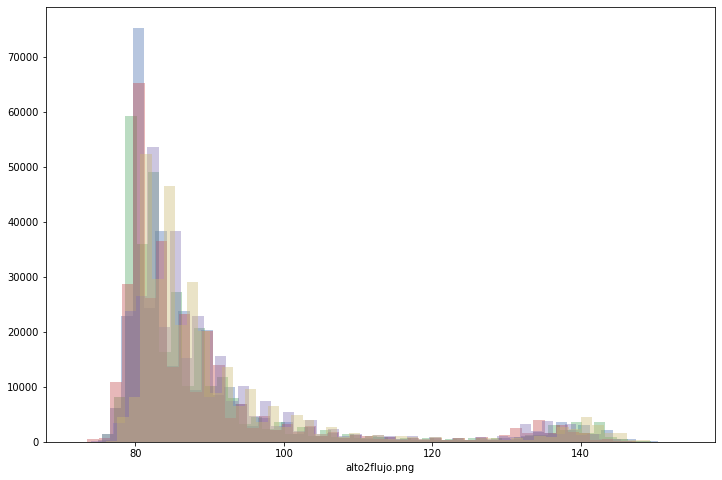

In [17]:
for i in intensities:
    sns.distplot(intensities[i],  kde=False)

In [19]:
kmeans = KMeans(n_clusters=2, random_state=0, verbose=False).fit(intensities)

In [55]:
kmeans.cluster_centers_.shape

(2, 5)

In [56]:
kmeans.cluster_centers_[:,0]

array([ 84.96916156, 131.74852391])

In [59]:
Ks = [kmeans.cluster_centers_[:,i].mean() for i in range(kmeans.cluster_centers_.shape[1])]
Ks

[108.35884273321545,
 108.20557516047501,
 107.0071272440723,
 108.72792777565184,
 110.86496622543946]

In [60]:
K = np.floor(kmeans.cluster_centers_.mean())
K

108.0

In [24]:
centers = np.floor(kmeans.cluster_centers_)

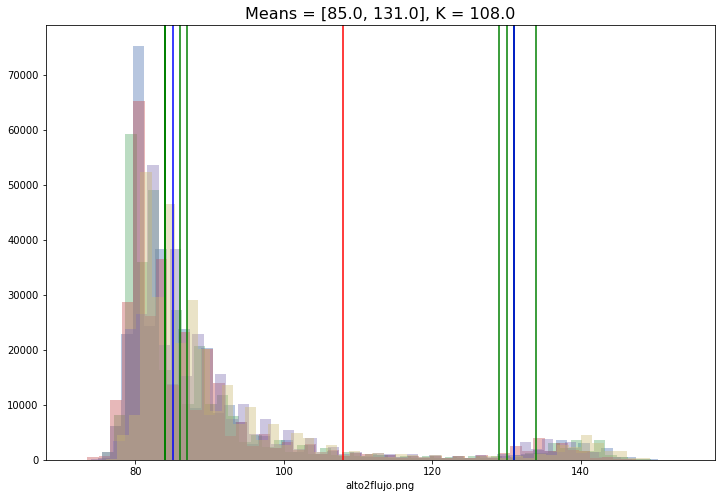

In [31]:
for i in intensities:
    sns.distplot(intensities[i],  kde=False)
plt.axvline(K, color='r')
lmap(lambda x: plt.axvline(x, color='g'), centers.flatten())
lmap(lambda x: plt.axvline(x, color='b'), lmap(np.mean, centers))
_ = plt.title(f"Means = {lmap(np.mean, centers)}, K = {K}", size=16)

Las líneas verdes respresentan las respectivas medias los cúmulos de intensidades de cada imagen. Las líneas azules representan las medias globales a través de las imágenes. La línea roja en medio de ambas es nuestro umbral.

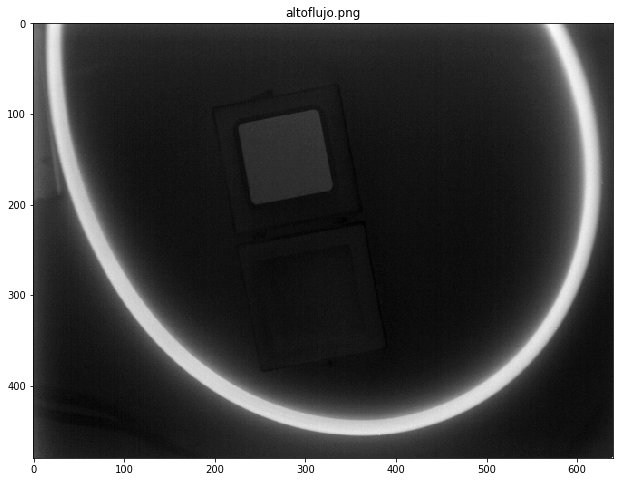

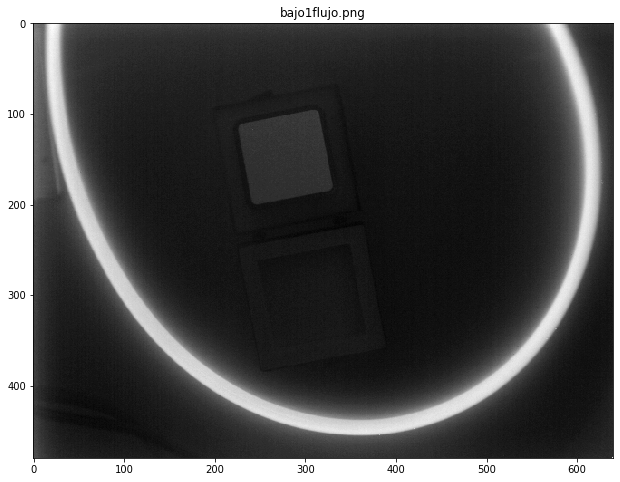

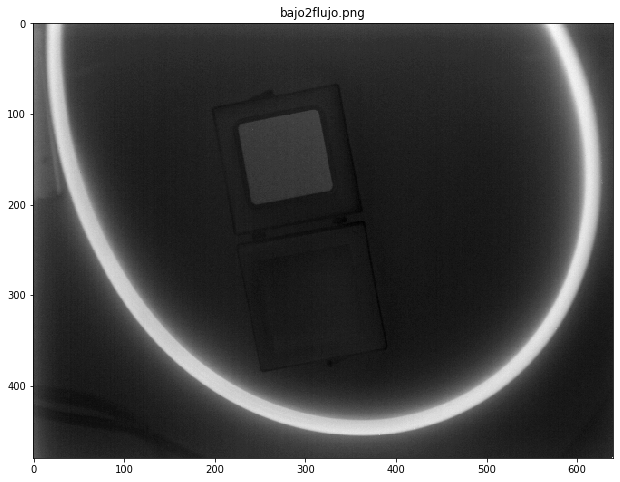

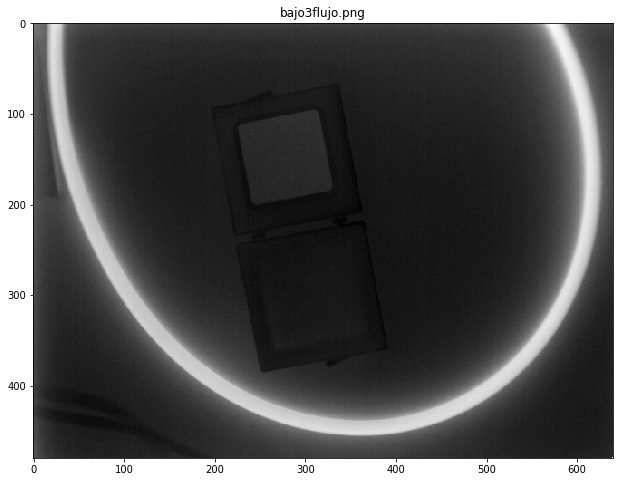

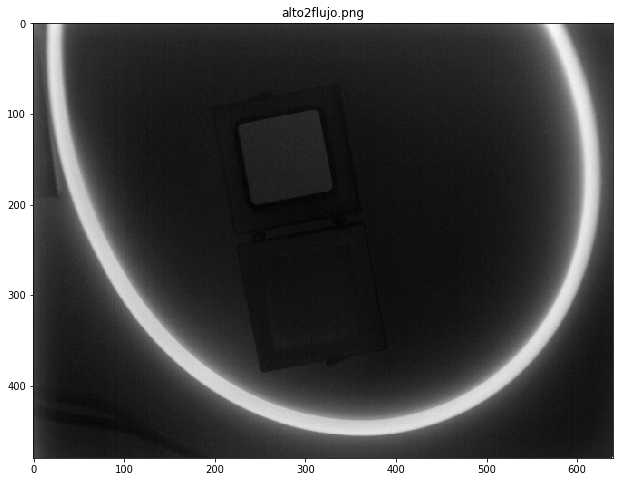

In [61]:
for nombre in mangueras.keys():
    plt.figure()
    plt.imshow(mangueras[nombre], cmap="gray")
    plt.title(nombre)

In [71]:
mangueras_segmentadas = copy.deepcopy(mangueras)

In [72]:
for i in mangueras_segmentadas.keys():
    mask = np.nonzero(mangueras_segmentadas[i] < K)
    mangueras_segmentadas[i][mask] = 0

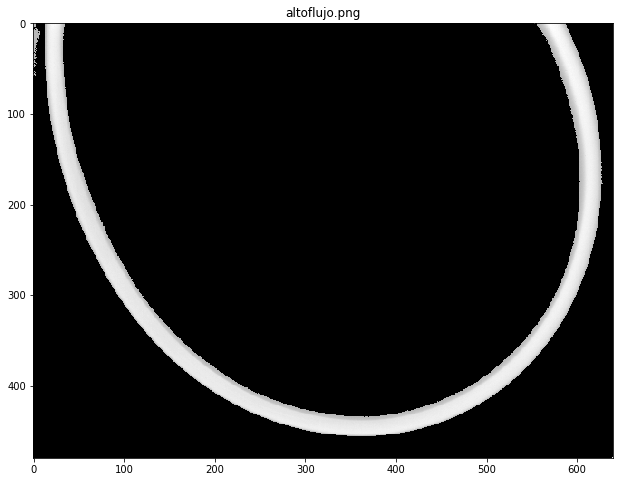

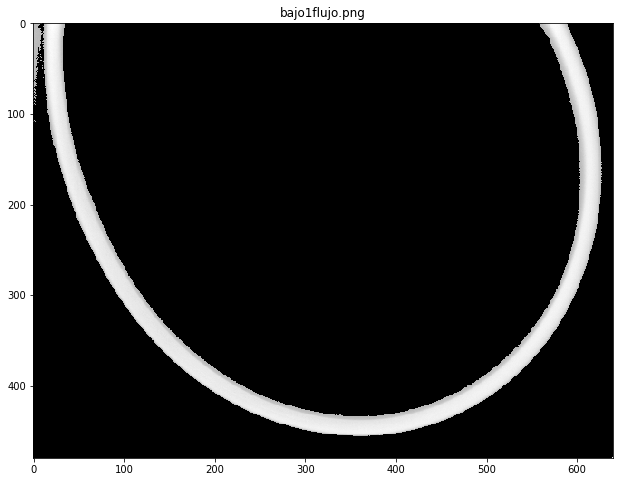

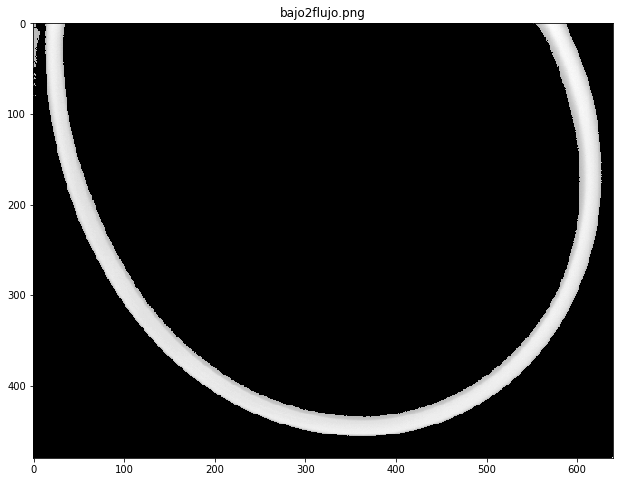

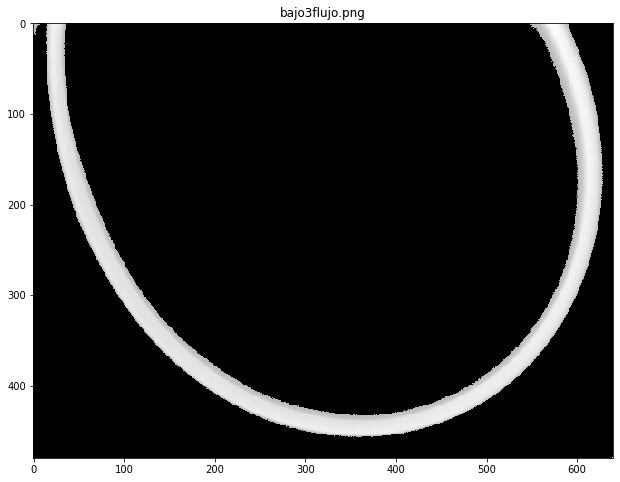

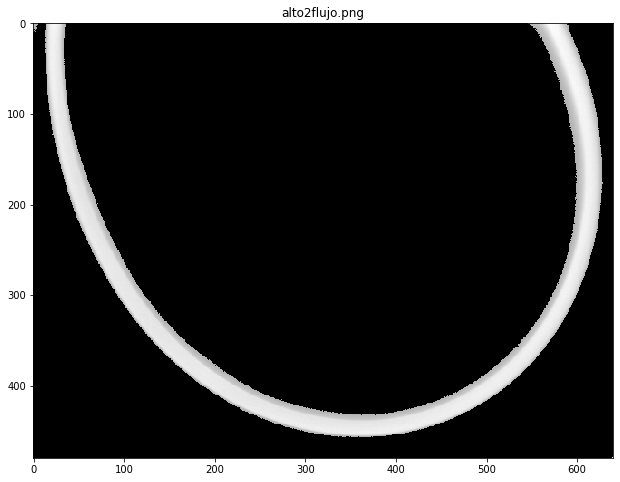

In [73]:
for nombre in mangueras_segmentadas.keys():
    plt.figure()
    plt.imshow(mangueras_segmentadas[nombre], cmap="gray")
    plt.title(nombre)

In [74]:
reg_ref_segmentadas = copy.deepcopy(mangueras)

In [75]:
for i in reg_ref_segmentadas.keys():
    mask = np.nonzero(reg_ref_segmentadas[i] > K)
    reg_ref_segmentadas[i][mask] = 0

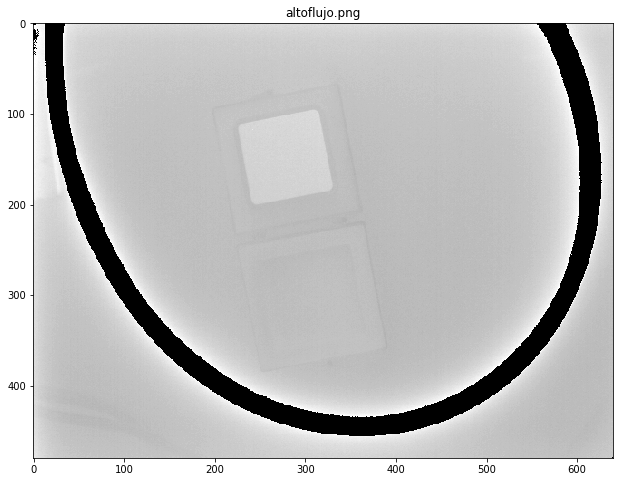

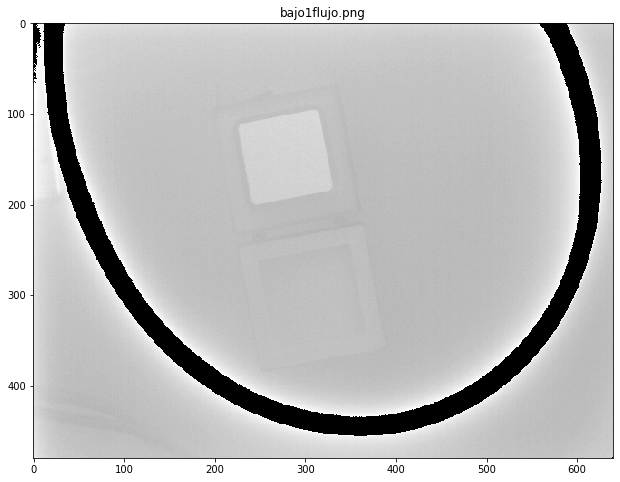

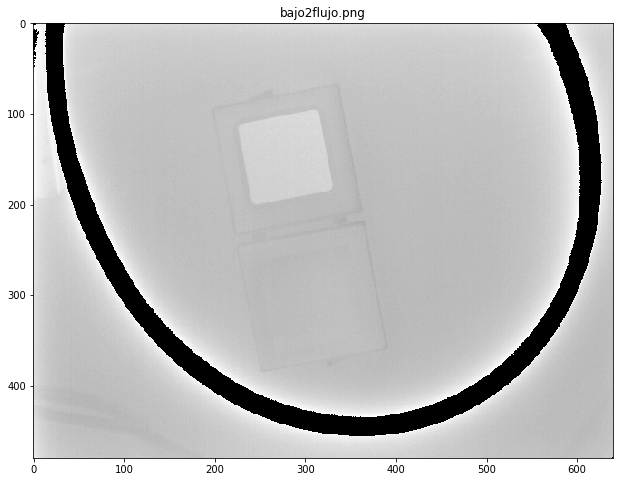

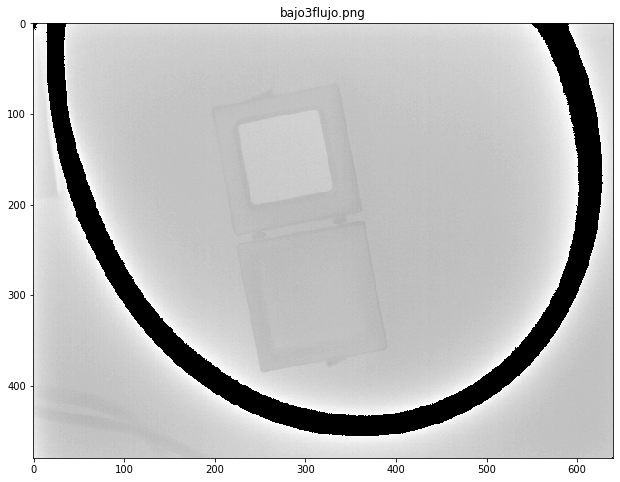

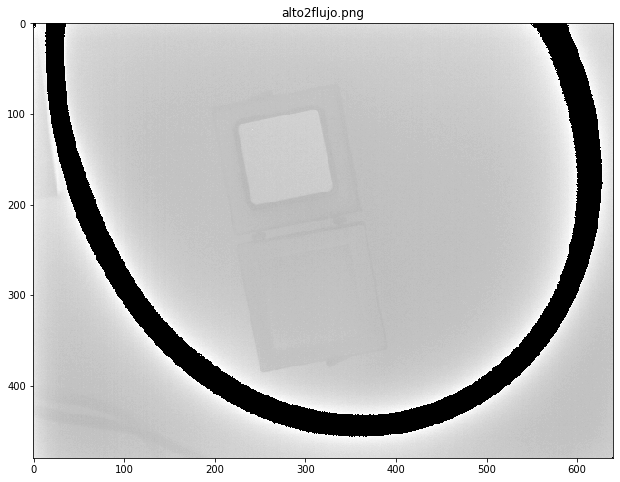

In [76]:
for nombre in reg_ref_segmentadas.keys():
    plt.figure()
    plt.imshow(reg_ref_segmentadas[nombre], cmap="gray")
    plt.title(nombre)

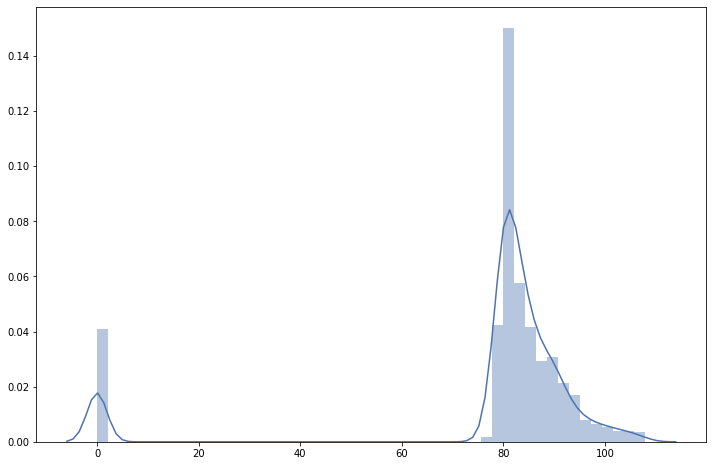

In [79]:
sns.distplot(reg_ref_segmentadas['altoflujo.png'].flatten())